# Recurrent NNR (LSTM) on equation of motion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import tensorflow.keras as ks

2023-05-09 14:28:38.957048: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 14:28:39.112495: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 14:28:39.113257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 14:28:40.436617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Defining equation of motions and create sample trajectories

Physical problem: Finding trajectory of particle P_0. Forces on particle 0 are gravity from two bodies B_1, B_2. 
While B_1 rests in center of coordinate system, while B_2 moves around B_1 on a circular trajectory.

In [2]:
# Defining a class that holds all information about a particle or body
class space_body():
    '''Class that holds position and mass in properties. Returns distance to other objects
    by calling method "dist_to_object()" Returns array with own positions by calling method ".pos()".
    Methods:
        .dist_to_object(position) Returns distance to objects located at position, position: 2D list-like
        .pos() Returns 2D list-like of own position
        .normalized_diff_vector(position) Returns normalized differential vector pointing to object located at
                position, position: 2D list-like'''
    def __init__(self, position, mass, radius):
        self.x = position[0]
        self.y = position[1]
        self.m = mass
        self.r = radius
        
    def pos(self):
        return np.array([self.x, self.y])
        
    def dist_to_object(self, position):
        return np.sqrt((self.x - position[0])**2 + (self.y - position[1])**2)
    
    def normalized_diff_vector(self, position):
        abs_value = np.sqrt((position[0] - self.x)**2 + (position[1] - self.y)**2)
        return np.array([position[0] - self.x, position[1] - self.y]) / abs_value
    
# Defining a class that hold additionally its velocity
class space_particle(space_body):
    '''Class that holds position, mass and velocity in properties. 
    Additional properties t_series, pos_series, vel_series store result of integration of equation of motion:
    t: Stores time steps
    pos: stores position vectors as 2D array, shape (timesteps, 2)
    vel: stores velocity vectors as 2D array, shape (timesteps, 2)
    Returns distance to other objects by calling method "dist_to_object()".
    Integrates equation of motion with property .integrate(), see details in doc string of method'''
    def __init__(self, position, velocity, mass, radius):
        self.x = position[0]
        self.y = position[1]
        self.v_x = velocity[0]
        self.v_y = velocity[1]
        self.m = mass
        self.r = radius
        self.solution = pd.DataFrame()

    def RK_dy_dt(self, t, y, G, B_1):
        '''Defining right hand side of motions of equations, to be able to pass them to Runge Kutta solver
        Force on P_0 by B_1 causes acceleration. Velocities are easily obtained from vector y.'''
        # Writing new values to position and velocity of P_0 object
        self.x = y[0]
        self.y = y[1]
        self.v_x = y[2]
        self.v_y = y[3]
        # Calculating absolut value of acceleration caused by gravitational force of B_1 on P_0
        if self.dist_to_object(B_1.pos()) < 0.05: # If true: avoid division by zero
            abs_acc = G * B_1.m * 0.05**(-2)
        else:
            abs_acc = G * B_1.m * self.dist_to_object(B_1.pos())**(-2)
        # Calculate x-component of acceleration
        acc_x = np.array([1, 0]) @ self.normalized_diff_vector(B_1.pos()) * abs_acc
        # Calculate y-component of acceleration
        acc_y = np.array([0, 1]) @ self.normalized_diff_vector(B_1.pos()) * abs_acc
        return [self.v_x, self.v_y, acc_x, acc_y]
    
    def integrate(self, G, Body, t_span, n_points, rtol=1E-5):
        '''Integrate equation of motion in presence of Body. Parameters:
        G: gravitational constant
        Body: space_body object, gravitation force of this body will act on particle
        t_span: tuple of two numerical values, defining time interval of integration
        n_points: integer defining number of steps in result of integration
        rtol: numerical value defining tolerance for Runge-Kutta solver
        
        Has no return value, fills property DataFrame "solution" with result of integration'''
        integration = sc.integrate.solve_ivp(lambda t, y: self.RK_dy_dt(t, y, G, Body), t_span=t_span, 
                                              y0=np.array([self.x, self.y, self.v_x, self.v_y]), 
                                              t_eval=np.linspace(t_span[0], t_span[1], n_points), rtol=1E-5)
        self.solution = self.solution.assign(
            t=integration.t,
            x=integration.y[0],
            y=integration.y[1],
            v_x=integration.y[2],
            v_y=integration.y[3]
        )
    
    def show_trajectory(self, bodies=None):
        '''Method to create an plot of trajectory (result of integration of equation of motion).
        Optional arguement "bodies", accepts list of space_body objects to be plottet additionally in plot'''
        fig, ax = plt.subplots()
        ax.set_xlabel('x-coordinate [a.u.]')
        ax.set_ylabel('y-coordinate [a.u.]')
        ax.set_aspect(aspect='equal', adjustable='box') # force same scale for both axes
        abs_max_axes = self.solution[['x', 'y']].abs().max().max() # maximum of absolute values of coordinates x,y
        ax.set_xlim(-abs_max_axes, abs_max_axes)
        ax.set_ylim(-abs_max_axes, abs_max_axes)
        ax.scatter(self.solution.x, self.solution.y, c=self.solution.t, s=8)
        if bodies != None:
            for i, body in enumerate(bodies):
                ax.scatter(body.x, body.y, c='k', s=2500)

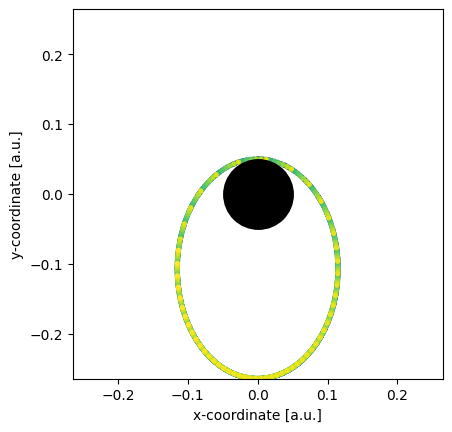

In [5]:
# First example: No B_2, just P_0 with force from B_1
G = 1 # Gravitational constant

# Create body in center of coordinate system with big mass
B_1 = space_body(position=[0, 0], mass=1.0, radius=0.05)
# Create particle that contains velocity, as well
P_0 = space_particle(position=[0, .05], velocity=[5.8, 0], mass=0.05, radius=0.05)
# Integrate equation of motion in presence of B_1
P_0.integrate(G, B_1, t_span=(0, 7), n_points=1000)
# Display result in a plot of trajectory
P_0.show_trajectory(bodies=[B_1])

In [229]:
P_0.solution[['x', 'y']].abs().max().max()

1.0

In [210]:
P_0.solution[['t', 'x']]

,t,x
0,0.000000,1.000000
1,0.151515,0.988501
2,0.303030,0.953758
3,0.454545,0.895006
4,0.606061,0.810876
...,...,...
95,14.393939,0.839355
96,14.545455,0.915405
97,14.696970,0.966535
98,14.848485,0.993922


In [167]:
solution = pd.DataFrame()
solution.assign(hallo=[0, 1])

,hallo
0,0
1,1


In [168]:
solution

""


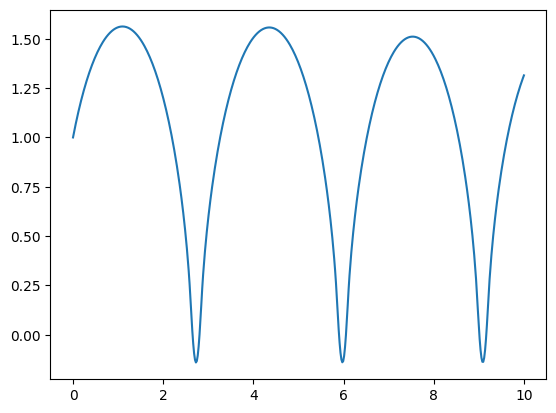

In [137]:
fig, ax = plt.subplots()
ax.plot(integration.t, integration.y[0, :])

In [90]:
integration.t

array([0.0000e+00, 1.0000e-04, 1.1000e-03, 1.1100e-02, 1.1110e-01,
       1.1111e+00, 1.0000e+01])